In [1]:
from icepyx import icesat2data as ipd
import os
import shutil
from pathlib import Path
from pprint import pprint

import pandas as pd

%matplotlib inline

# Download ATL06 data

In [2]:
short_name = 'ATL06'
spatial_extent = [ -50.71,  65.73, -45.32,  68.08]
date_range = ['2019-06-01','2019-06-05']

In [3]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)

print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)

ATL06
['2019-06-01', '2019-06-05']
00:00:00
23:59:59
003
['bounding box', [-50.71, 65.73, -45.32, 68.08]]


In [4]:
region_a.avail_granules(ids=True)

['ATL06_20190601071608_09780303_003_01.h5',
 'ATL06_20190601200102_09860305_003_01.h5',
 'ATL06_20190605070748_10390303_003_01.h5',
 'ATL06_20190605195242_10470305_003_01.h5']

In [5]:
earthdata_emails = {'tsnow03':'tasha.snow@colorado.edu',
                 'fperez': 'fernando.perez@berkeley.edu',
                 'alicecima':'alice_cima@berkeley.edu',
                 'grigsbye':'grigsby@mines.edu'
                    # add your name here
                }

user = 'tsnow03'
region_a.earthdata_login(user, earthdata_emails[user])

Earthdata Login password:  ············


In [6]:
# All possible variables
region_a.order_vars.avail(options=True)

var_list inputs: atlas_sdp_gps_epoch, control, data_end_utc, data_start_utc, end_cycle, end_delta_time, end_geoseg, end_gpssow, end_gpsweek, end_orbit, end_region, end_rgt, granule_end_utc, granule_start_utc, qa_at_interval, release, start_cycle, start_delta_time, start_geoseg, start_gpssow, start_gpsweek, start_orbit, start_region, start_rgt, version, dt_hist, fit_maxiter, fpb_maxiter, maxiter, max_res_ids, min_dist, min_gain_th, min_n_pe, min_n_sel, min_signal_conf, n_hist, nhist_bins, n_sigmas, proc_interval, qs_lim_bsc, qs_lim_hrs, qs_lim_hsigma, qs_lim_msw, qs_lim_snr, qs_lim_sss, rbin_width, sigma_beam, sigma_tx, t_dead, atl06_quality_summary, delta_time, h_li, h_li_sigma, latitude, longitude, segment_id, sigma_geo_h, fpb_mean_corr, fpb_mean_corr_sigma, fpb_med_corr, fpb_med_corr_sigma, fpb_n_corr, med_r_fit, tx_mean_corr, tx_med_corr, dem_flag, dem_h, geoid_h, dh_fit_dx, dh_fit_dx_sigma, dh_fit_dy, h_expected_rms, h_mean, h_rms_misfit, h_robust_sprd, n_fit_photons, n_seg_pulses,

In [49]:
# Choose variables to order
# region_a.order_vars.remove(all=True)
#region_a.order_vars.append(defaults=True)
#from IPython.display import JSON
#JSON(region_a.order_vars.wanted)

In [7]:
region_a.order_vars.append(var_list=['latitude','longitude','h_li','h_li_sigma','atl06_quality_summary','delta_time',
                                      'signal_selection_source','snr_significance','h_robust_sprd','dh_fit_dx','bsnow_conf',
                                      'cloud_flg_asr','cloud_flg_atm','msw_flag','bsnow_h','bsnow_od','layer_flag','bckgrd',
                                      'e_bckgrd','n_fit_photons','end_geoseg','segment_id','w_surface_window_final'])
from IPython.display import JSON
JSON(region_a.order_vars.wanted)

<IPython.core.display.JSON object>

Now, specify our coverage request with the wanted variables:

In [8]:
region_a.subsetparams(Coverage=region_a.order_vars.wanted);

In [9]:
region_a.order_granules()

Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000701895
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [10]:
# View a short list of order IDs:
region_a.granules.orderIDs

['5000000701895']

In [11]:
path = './download'
# without variable subsetting, or with variable subsetting if you have run region_a.order_granules(Coverage=region_a.order_vars.wanted)
region_a.download_granules(path)

Beginning download of zipped output...
Data request 5000000701895 of  1  order(s) is downloaded.
Download complete


In [16]:
!du -csh ./download

9.5M	./download
9.5M	total


# Build Pandas DataFrame

Some utility functions

In [63]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """Converte GPS time to decimal years."""
    dt = Time(time, format='gps').decimalyear
    
    return pandas.to_datetime(dt)


def orbit_type(time, lat, tmax=1):
    """Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


In [ ]:
pd.to_datetime(dataf)

In [62]:
import h5py
import numpy as np

def read_atl06(fname, outdir='data', bbox=None):
    """Read one ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    
    # Loop trough beams
    dataframes = []  # one dataframe per track
    
    with h5py.File(fname, 'r') as fi:
        # Check which ground tracks are present in this file
        gtracks = sorted(['/'+k for k in fi.keys() if k.startswith('gt')])
        print('Available ground tracks:', gtracks)
    
        for k, g in enumerate(gtracks): 
            # Read in data for a single beam
            data = {}
            data['ground_track'] = None # Put it first in the dict for column ordering
            data['t_year'] = None
            
            # Load vars into memory (include as many as you want)
            data['lat'] = fi[g+'/land_ice_segments/latitude'][:]
            data['lon'] = fi[g+'/land_ice_segments/longitude'][:]
            data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:]
            data['h_li'] = fi[g+'/land_ice_segments/h_li'][:]
            data['s_li'] = fi[g+'/land_ice_segments/h_li_sigma'][:]
            data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            data['s_fg'] = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            data['snr'] = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            data['h_rb'] = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            data['dh_fit_dx'] = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/cloud_flg_asr'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/cloud_flg_atm'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/msw_flag'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bsnow_h'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bsnow_od'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/layer_flag'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bckgrd'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/geophysical/e_bckgrd'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/fit_statistics/n_fit_photons'][:]
            data['f_sn'] = fi['/ancillary_data/end_geoseg'][:]
            data['f_sn'] = fi[g+'/segment_quality/segment_id'][:]
            data['f_sn'] = fi[g+'/land_ice_segments/fit_statistics/w_surface_window_final'][:]
            
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value

            '''
            ***Continue adding columns for these vars, repeated as above. Need to find group/file 
               structure for each in https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL06_data_dict_v003.pdf):
               cloud_flg_asr, cloud_flg_atm, msw_flag, bsnow_h, bsnow_od, layer_flag, bckgrd, 
               e_bckgrd, n_fit_photons, end_geoseg, segment_id, w_surface_window_final
            ''' 
            
#             data['dac'] = fi[g+'/land_ice_segments/geophysical/dac'][:]
#             data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:]
#             data['tide_earth'] = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
#             data['tide_load'] = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
#             data['tide_ocean'] = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
#             data['tide_pole'] = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
                
#                rgt = fi['/orbit_info/rgt'][:]                           # single value
#                 t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
#                 beam_type = fi[g].attrs["atlas_beam_type"].decode()      # strong/weak (str)
#                 spot_number = fi[g].attrs["atlas_spot_number"].decode()  # number (str)
            
            # Time in GPS seconds (secs sinde Jan 5, 1980)
            t_gps = t_ref + data['t_dt']

            # Time in decimal years
            data['t_year'] = gps2dyr(t_gps)
        
            # Assume all vector fields are of the length of the first. TODO - check?
            npts = len(data['lat'])
            data['ground_track'] = [g[1:]]*npts
                    
            # Make a dataframe out of our data dict and store it.
            dataframes.append(pd.DataFrame.from_dict(data))
        
    return dataframes

def atl06_2_df(files):
    """Return a single Pandas dataframe from a list of HDF5 ATL-06 data files.
    """
    dataframes = []
    for f in files:
        dataframes.extend(read_atl06(f))
    
    ndfs = len(dataframes)
    i = 0
    
    # pd.concat can only work with up to 10 dataframes at a time,
    # so we need to chunk this up
    new_dfs = []
    while i <= ndfs:
        i_end = i+10 if i+10 < ndfs else ndfs
        dfs = dataframes[i:i_end]
        if not dfs:
            break
        new_dfs.append(pd.concat(dfs))
        i = i_end
    
    return pd.concat(new_dfs)

In [64]:
path = Path('download')
dataf = atl06_2_df(path.glob('*.h5'))

Available ground tracks: ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
[1.24345467e+09 1.24345467e+09 1.24345467e+09 ... 1.24345471e+09
 1.24345471e+09 1.24345471e+09]
[1.24345467e+09 1.24345467e+09 1.24345467e+09 ... 1.24345471e+09
 1.24345471e+09 1.24345471e+09]
[1.24345467e+09 1.24345467e+09 1.24345467e+09 ... 1.24345471e+09
 1.24345471e+09 1.24345471e+09]
[1.24345467e+09 1.24345467e+09 1.24345467e+09 ... 1.24345471e+09
 1.24345471e+09 1.24345471e+09]
[1.24345467e+09 1.24345467e+09 1.24345467e+09 ... 1.24345471e+09
 1.24345471e+09 1.24345471e+09]
[1.24345467e+09 1.24345467e+09 1.24345467e+09 ... 1.24345471e+09
 1.24345471e+09 1.24345471e+09]
Available ground tracks: ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
[1.24340870e+09 1.24340870e+09 1.24340870e+09 ... 1.24340872e+09
 1.24340872e+09 1.24340872e+09]
[1.24340870e+09 1.24340870e+09 1.24340870e+09 ... 1.24340872e+09
 1.24340872e+09 1.24340872e+09]
[1.24340871e+09 1.24340871e+09 1.24340871e+09 ... 1.24340872e+09

In [65]:
dataf.describe()

,t_year,lat,lon,t_dt,h_li,s_li,q_flag,s_fg,snr,h_rb,dh_fit_dx,f_sn
count,252416.000000,252416.000000,252416.000000,2.524160e+05,2.524160e+05,2.524160e+05,252416.000000,252416.000000,252416.000000,2.524160e+05,2.524160e+05,2.524160e+05
mean,2019.422282,66.969175,-47.371667,4.485305e+07,inf,inf,0.022479,0.037941,0.004300,inf,inf,inf
std,0.005127,0.672515,1.208278,1.616755e+05,inf,inf,0.148235,0.291183,0.050107,inf,inf,inf
min,2019.414533,65.730013,-49.075188,4.460868e+07,1.244566e+03,3.356113e-03,0.000000,0.000000,0.000000,3.438600e-03,-7.799568e-01,3.000000e+00
25%,2019.415992,66.391515,-48.461860,4.465467e+07,1.483578e+03,1.438970e-02,0.000000,0.000000,0.000000,1.277712e-01,-4.686356e-03,3.000000e+00
50%,2019.425476,67.015728,-47.793800,4.495378e+07,1.679594e+03,2.080464e-02,0.000000,0.000000,0.000000,1.596234e-01,-8.364916e-04,3.000000e+00
75%,2019.426934,67.548462,-46.083928,4.499976e+07,2.108787e+03,3.137868e-02,0.000000,0.000000,0.000000,1.908423e-01,3.726661e-03,3.000000e+00
max,2019.426935,68.079999,-45.320004,4.499979e+07,3.402823e+38,3.402823e+38,1.000000,3.000000,0.941731,3.402823e+38,3.402823e+38,3.402823e+38


In [16]:
dataf.q_flag.value_counts()

0    246742
1      5674
Name: q_flag, dtype: int64

In [17]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252416 entries, 0 to 13177
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ground_track  252416 non-null  object 
 1   lat           252416 non-null  float64
 2   lon           252416 non-null  float64
 3   h_li          252416 non-null  float32
 4   s_li          252416 non-null  float32
 5   q_flag        252416 non-null  int8   
 6   s_fg          252416 non-null  int8   
 7   snr           252416 non-null  float32
 8   h_rb          252416 non-null  float32
 9   dh_fit_dx     252416 non-null  float32
 10  f_sn          252416 non-null  float32
dtypes: float32(6), float64(2), int8(2), object(1)
memory usage: 14.0+ MB


In [54]:
dataf.head()

,ground_track,t_year,lat,lon,t_dt,h_li,s_li,q_flag,s_fg,snr,h_rb,dh_fit_dx,f_sn
0,gt1l,2019.415991,68.079999,-47.455941,4.465465e+07,1681.167114,0.008938,0,0,0.0,0.118632,-0.006507,3.0
1,gt1l,2019.415991,68.079821,-47.455997,4.465465e+07,1681.033203,0.012630,0,0,0.0,0.137092,-0.009821,3.0
2,gt1l,2019.415991,68.079643,-47.456053,4.465465e+07,1680.882568,0.011899,0,0,0.0,0.124785,-0.004994,3.0
3,gt1l,2019.415991,68.079464,-47.456110,4.465465e+07,1680.766113,0.011329,0,0,0.0,0.123428,-0.006852,3.0
4,gt1l,2019.415991,68.079286,-47.456168,4.465465e+07,1680.677124,0.011673,0,0,0.0,0.124423,-0.005056,3.0


# Assimilating VIIRS automatically

In [46]:
import utils
import importlib
importlib.reload(utils)
from utils import associate
import datetime as dt

In [47]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

# f_.visititems(print_attrs) 

def date_from_julian_date(yrj):
    d = dt.datetime.strptime(yrj, '%Y%j').date()
    return d

In [29]:
dataf.iloc[0]

ground_track           gt1l
t_year              2019.42
lat                   68.08
lon                -47.4559
t_dt            4.46547e+07
h_li                1681.17
s_li             0.00893804
q_flag                    0
s_fg                      0
snr                       0
h_rb               0.118632
dh_fit_dx       -0.00650704
f_sn                      3
Name: 0, dtype: object

In [41]:
# for Cfile in Cfiles:
Cfile = '/home/jovyan/CloudMask/CloudData/VIIRScld/CLDMSK_L2_VIIRS_SNPP.A2019156.0754.001.2019156185728.nc'
f_ = h5py.File(Cfile) 
f_geo = [f_['geolocation_data/latitude'][:].max(),f_['geolocation_data/latitude'][:].min(),
    f_['geolocation_data/longitude'][:].min(),f_['geolocation_data/longitude'][:].max()]
f_day = Cfile[-33:-26]
f_t = int(Cfile[-25:-21])

    
x,y = dataf['lon'].iloc[0],dataf['lat'].iloc[0]


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
f_date = date_from_julian_date(f_day)

In [33]:
f_ = h5py.File('/home/jovyan/CloudMask/CloudData/VIIRScld/CLDMSK_L2_VIIRS_SNPP.A2019156.0754.001.2019156185728.nc')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


QA_dimension
    CLASS: b'DIMENSION_SCALE'
    NAME: b'This is a netCDF dimension but not a netCDF variable.        10'
    REFERENCE_LIST: [(<HDF5 object reference>, 2)]
byte_segment
    CLASS: b'DIMENSION_SCALE'
    NAME: b'This is a netCDF dimension but not a netCDF variable.         6'
    REFERENCE_LIST: [(<HDF5 object reference>, 0)]
geolocation_data
geolocation_data/latitude
    long_name: b'Latitudes of pixel locations'
    units: b'degrees_north'
    _FillValue: [-999.9]
    valid_min: [-90.]
    valid_max: [90.]
    DIMENSION_LIST: [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
geolocation_data/longitude
    long_name: b'Longitudes of pixel locations'
    units: b'degrees_east'
    _FillValue: [-999.9]
    valid_min: [-180.]
    valid_max: [180.]
    DIMENSION_LIST: [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]
geolocation_data/sensor_azimuth
    long_name: b'Sensor azimuth an

In [46]:
geo

[88.927574, 58.31502, -176.30638, -10.019012]

In [34]:
associate(dataf,f_)

KeyError: "Unable to open object (object 'geolocation_data' doesn't exist)"

In [35]:
dataf.describe()

,lat,lon,h_li,s_li,q_flag,s_fg,snr,h_rb,dh_fit_dx,f_sn,Integer_Cloud_Mask
count,252416.000000,252416.000000,2.524160e+05,2.524160e+05,252416.000000,252416.000000,252416.000000,2.524160e+05,2.524160e+05,2.524160e+05,252416.000000
mean,66.969175,-47.371667,inf,inf,0.022479,0.037941,0.004300,inf,inf,inf,2.702986
std,0.672515,1.208278,inf,inf,0.148235,0.291183,0.050107,inf,inf,inf,0.880359
min,65.730013,-49.075188,1.244566e+03,3.356113e-03,0.000000,0.000000,0.000000,3.438600e-03,-7.799568e-01,3.000000e+00,0.000000
25%,66.391515,-48.461860,1.483578e+03,1.438970e-02,0.000000,0.000000,0.000000,1.277712e-01,-4.686356e-03,3.000000e+00,3.000000
50%,67.015728,-47.793800,1.679594e+03,2.080464e-02,0.000000,0.000000,0.000000,1.596234e-01,-8.364916e-04,3.000000e+00,3.000000
75%,67.548462,-46.083928,2.108787e+03,3.137868e-02,0.000000,0.000000,0.000000,1.908423e-01,3.726661e-03,3.000000e+00,3.000000
max,68.079999,-45.320004,3.402823e+38,3.402823e+38,1.000000,3.000000,0.941731,3.402823e+38,3.402823e+38,3.402823e+38,3.000000


In [36]:
import xarray as xr

In [89]:
xray = xr.Dataset.from_dataframe(dataf)

In [90]:
xray

<xarray.Dataset>
Dimensions:             (index: 252416)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 13174 13175 13176 13177
Data variables:
    ground_track        (index) object 'gt1l' 'gt1l' 'gt1l' ... 'gt3r' 'gt3r'
    lat                 (index) float64 68.08 68.08 68.08 ... 65.73 65.73 65.73
    lon                 (index) float64 -47.46 -47.46 -47.46 ... -49.08 -49.08
    h_li                (index) float32 1681.1671 1681.0332 ... 1479.2249
    s_li                (index) float32 0.008938037 0.012630311 ... 0.042509172
    q_flag              (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    s_fg                (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    snr                 (index) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h_rb                (index) float32 0.11863171 0.13709156 ... 0.19301407
    dh_fit_dx           (index) float32 -0.006507039 ... -0.0005083084
    f_sn                (index) float32 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    Integer_Cloud_Mask  (index) int8 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3
    idx                 (index) int64 10024279 10024279 ... 9202093 9202093

In [43]:
from sklearn.neighbors import BallTree


In [60]:
def associate2(dataframe, swath, variable='Integer_Cloud_Mask'):
    """Takes a dataframe, and a satellite file, and extracts the
    selected variable as a new column.

    Assumes that data coordinates are in lat/lon
    Assumes dataframe higher resolution than swath"""
    
    # grab swath coordinates
    # TODO; make general for inferring lat/lon paths
    latS = np.array(swath['geolocation_data']['latitude'])
    lonS = np.array(swath['geolocation_data']['longitude'])

    S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
    S_rad *= np.pi / 180.

    # grab dataframe coords
    latF = dataframe.lat.values
    lonF = dataframe.lon.values

    F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
    F_rad *= np.pi / 180.

    # build spatial tree; find matches
    print("building tree")
    S_Ball = BallTree(S_rad,metric='haversine')
    print("searching data")
    indicies = S_Ball.query(F_rad, k=1,
                            breadth_first=True,
                            return_distance=False)
    
    extract = swath['geophysical_data'][variable].value
    new_column = extract.ravel()[indicies]
    dataframe[variable] = new_column

    # get data for overlay
    shp = swath['geophysical_data'][variable].shape
    mask = np.zeros_like(extract, dtype=bool)
    mask.ravel()[indicies] = True
    return mask, indicies



In [63]:
mask, idx = associate2(dataf,f_)

building tree
searching data


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


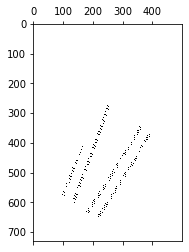

In [59]:
plt.spy(mask[2500:,1700:2200])

In [50]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [62]:
xray

<xarray.Dataset>
Dimensions:             (index: 252416)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 13174 13175 13176 13177
Data variables:
    ground_track        (index) object 'gt1l' 'gt1l' 'gt1l' ... 'gt3r' 'gt3r'
    lat                 (index) float64 68.08 68.08 68.08 ... 65.73 65.73 65.73
    lon                 (index) float64 -47.46 -47.46 -47.46 ... -49.08 -49.08
    h_li                (index) float32 1681.1671 1681.0332 ... 1479.2249
    s_li                (index) float32 0.008938037 0.012630311 ... 0.042509172
    q_flag              (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    s_fg                (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    snr                 (index) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h_rb                (index) float32 0.11863171 0.13709156 ... 0.19301407
    dh_fit_dx           (index) float32 -0.006507039 ... -0.0005083084
    f_sn                (index) float32 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    Integer_Cloud_Mask  (index) int8 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3

In [69]:
idx[:50]

array([[10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10024279],
       [10021080],
       [10021080],
       [10021080],
       [10021080]])

In [70]:
dataf['idx'] = idx

In [71]:
dataf

,ground_track,lat,lon,h_li,s_li,q_flag,s_fg,snr,h_rb,dh_fit_dx,f_sn,Integer_Cloud_Mask,idx
0,gt1l,68.079999,-47.455941,1681.167114,0.008938,0,0,0.0,0.118632,-0.006507,3.0,3,10024279
1,gt1l,68.079821,-47.455997,1681.033203,0.012630,0,0,0.0,0.137092,-0.009821,3.0,3,10024279
2,gt1l,68.079643,-47.456053,1680.882568,0.011899,0,0,0.0,0.124785,-0.004994,3.0,3,10024279
3,gt1l,68.079464,-47.456110,1680.766113,0.011329,0,0,0.0,0.123428,-0.006852,3.0,3,10024279
4,gt1l,68.079286,-47.456168,1680.677124,0.011673,0,0,0.0,0.124423,-0.005056,3.0,3,10024279
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13173,gt3r,65.730786,-49.074994,1479.279053,0.058440,0,0,0.0,0.233734,0.003487,3.0,3,9202093
13174,gt3r,65.730608,-49.075042,1479.295532,0.038120,0,0,0.0,0.217718,0.009203,3.0,3,9202093
13175,gt3r,65.730430,-49.075091,1479.258545,0.034046,0,0,0.0,0.182698,-0.011706,3.0,3,9202093
13176,gt3r,65.730251,-49.075139,1479.196045,0.037711,0,0,0.0,0.207854,-0.000793,3.0,3,9202093


In [75]:
dataf.groupby('idx').h_li.mean()

idx
8869152     2413.775146
8872352     2412.567627
8875551     2411.411133
8878751     2408.125000
8878755     2401.977051
               ...     
10104314    1516.200317
10104319    1451.449829
10107518    1444.441284
10110717    1465.045532
10113917    1463.444580
Name: h_li, Length: 2475, dtype: float32

In [83]:
dataf.groupby(idx.flatten()).h_li.mean()

8869152     2413.775146
8872352     2412.567627
8875551     2411.411133
8878751     2408.125000
8878755     2401.977051
               ...     
10104314    1516.200317
10104319    1451.449829
10107518    1444.441284
10110717    1465.045532
10113917    1463.444580
Name: h_li, Length: 2475, dtype: float32

In [81]:
shape(idx.flat)

(252416,)

In [104]:
temp = xray.groupby('idx')

In [111]:
temp.reduce?

Signature: temp.reduce(func, dim=None, keep_attrs=None, **kwargs)
Docstring:
Reduce the items in this group by applying `func` along some
dimension(s).

Parameters
----------
func : function
    Function which can be called in the form
    `func(x, axis=axis, **kwargs)` to return the result of collapsing
    an np.ndarray over an integer valued axis.
dim : `...`, str or sequence of str, optional
    Dimension(s) over which to apply `func`.
axis : int or sequence of int, optional
    Axis(es) over which to apply `func`. Only one of the 'dimension'
    and 'axis' arguments can be supplied. If neither are supplied, then
    `func` is calculated over all dimension for each group item.
keep_attrs : bool, optional
    If True, the datasets's attributes (`attrs`) will be copied from
    the original object to the new one.  If False (default), the new
    object will be returned without attributes.
**kwargs : dict
    Additional keyword arguments passed on to `func`.

Returns
-------
reduced :

In [87]:
xr.DataArray(idx.flatten(),name='idx')

<xarray.DataArray 'idx' (dim_0: 252416)>
array([10024279, 10024279, 10024279, ...,  9202093,  9202093,  9202093])
Dimensions without coordinates: dim_0

In [97]:
xray.h_li[:50]

<xarray.DataArray 'h_li' (index: 50)>
array([1681.1671, 1681.0332, 1680.8826, 1680.7661, 1680.6771, 1680.5906,
       1680.5017, 1680.4003, 1680.3306, 1680.3057, 1680.2445, 1680.154 ,
       1680.0974, 1680.0483, 1679.9585, 1679.8813, 1679.8041, 1679.7041,
       1679.5951, 1679.5123, 1679.406 , 1679.2731, 1679.1458, 1679.0913,
       1679.0428, 1678.8878, 1678.7472, 1678.6771, 1678.5955, 1678.5282,
       1678.4364, 1678.2891, 1678.1946, 1678.114 , 1678.0094, 1677.9333,
       1677.8728, 1677.8041, 1677.7333, 1677.6865, 1677.6263, 1677.5552,
       1677.5076, 1677.4456, 1677.3518, 1677.2915, 1677.2076, 1677.1104,
       1677.0397, 1676.9884], dtype=float32)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49

In [110]:
xray

<xarray.Dataset>
Dimensions:             (index: 252416)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 13174 13175 13176 13177
Data variables:
    ground_track        (index) object 'gt1l' 'gt1l' 'gt1l' ... 'gt3r' 'gt3r'
    lat                 (index) float64 68.08 68.08 68.08 ... 65.73 65.73 65.73
    lon                 (index) float64 -47.46 -47.46 -47.46 ... -49.08 -49.08
    h_li                (index) float32 1681.1671 1681.0332 ... 1479.2249
    s_li                (index) float32 0.008938037 0.012630311 ... 0.042509172
    q_flag              (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    s_fg                (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    snr                 (index) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h_rb                (index) float32 0.11863171 0.13709156 ... 0.19301407
    dh_fit_dx           (index) float32 -0.006507039 ... -0.0005083084
    f_sn                (index) float32 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    Integer_Cloud_Mask  (index) int8 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3
    idx                 (index) int64 10024279 10024279 ... 9202093 9202093

In [112]:
ls

ATL03Retrieval.ipynb                                     README.md
ATL06Retrieval_xray.ipynb                                __pycache__/
CLDMSK_L2_VIIRS_SNPP.A2014195.1442.001.2019071103127.nc  download/
CloudMask.ipynb                                          utils.py
LICENSE
